### Gmarket
- 베스트 상품 200개 데이터 수집
- 상품의 이미지 200개 다운로드

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

#### 1. URL 찾기

In [38]:
url = 'https://www.gmarket.co.kr/n/best'

#### 2. request > response : str(html)

In [39]:
response = requests.get(url)
response.text[:200]

'<!DOCTYPE html><html lang="ko" class="no-js"><head><meta name="viewport" content="width=980"/><meta charSet="utf-8"/><meta http-equiv="X-UA-Compatible" content="ie=edge"/><meta name="description" cont'

#### 3. bs > DataFrame

In [40]:
docm = BeautifulSoup(response.text, 'html.parser')
type(docm)

bs4.BeautifulSoup

In [41]:
elements = docm.select('#gBestWrap > div.best-list > ul > li') 
len(elements)

200

In [42]:
element = elements[0]
data = {
    'title' : element.select_one('.itemname').text,
    'link' : element.select_one('.itemname').get('href'),
    'img' : 'http:'+element.select_one('.image__lazy').get('src'),
    'o_price' : element.select_one('.o-price').text,
    's_price' : element.select_one('.s-price').text.split(' ')[0],
}
data

{'title': '네추럴라이즈 키즈 멀티비타민 C/D 60꾸미 3종 3병',
 'link': 'http://item.gmarket.co.kr/Item?goodscode=3113057185&ver=20230825',
 'img': 'http://gdimg.gmarket.co.kr/3113057185/still/300?ver=20230825',
 'o_price': '정가22,900원',
 's_price': '할인가21,760원'}

In [43]:
items = []
for element in elements:
    items.append({
        'title' : element.select_one('.itemname').text,
        'link' : element.select_one('.itemname').get('href'),
        'img' : 'http:'+element.select_one('.image__lazy').get('src'),
        'o_price' : element.select_one('.o-price').text,
        's_price' : element.select_one('.s-price').text.split(' ')[0],
    })
df = pd.DataFrame(items)
df.tail(2)

,title,link,img,o_price,s_price
198,[블랜더보틀](오플닷컴) 스트라다 단열 스테인레스 스틸 쉐이커 보틀 보냉 텀블러 오...,http://item.gmarket.co.kr/Item?goodscode=22006...,http://gdimg.gmarket.co.kr/2200634054/still/30...,"정가36,200원","할인가23,850원"
199,[또온나](4장세트 쿠폰가11610원) 여성 노와이어 데일리 브라 편안하게 잡아주는...,http://item.gmarket.co.kr/Item?goodscode=23405...,http://gdimg.gmarket.co.kr/2340557643/still/30...,"정가43,000원","할인가12,900원"


In [44]:
elements[0].select_one('.s-price').text.split(' ')[0]

'할인가21,760원'

- 전처리

In [45]:
df[['o_price', 's_price']].tail(2)

,o_price,s_price
198,"정가36,200원","할인가23,850원"
199,"정가43,000원","할인가12,900원"


In [47]:
df1 = df.copy()
df1['o_price'] = df1['o_price'].apply(lambda data : data.replace(',','')[2:-1])
df1.head()[['o_price', 's_price']]

,o_price,s_price
0,22900,21760
1,15000,9980
2,25800,12900
3,,45900
4,325000,144900


In [50]:
import re # 텍스트 데이터 전처리 : 정규표현식
df1['s_price'] = df1['s_price'].apply(lambda data : re.findall('[0-9]+',data)[0].replace(',',''))
df1.head()[['o_price', 's_price']]

,o_price,s_price
0,22900,21760
1,15000,9980
2,25800,12900
3,,45900
4,325000,144900


In [59]:
df2 = df1.copy()
df2.loc[df2['o_price']=='', 'o_price'] = df2.loc[df2['o_price']=='', 's_price'] 
df2.head()[['o_price', 's_price']]

,o_price,s_price
0,22900,21760
1,15000,9980
2,25800,12900
3,45900,45900
4,325000,144900


In [60]:
df2['o_price'] = df2['o_price'].astype('int') 
df2['s_price'] = df2['s_price'].astype('int') 
df2.dtypes

title      object
link       object
img        object
o_price     int32
s_price     int32
dtype: object

In [64]:
import numpy as np
df2['discount'] = np.round((1-df2['s_price']/df2['o_price'])*100, 2)
df2.tail(2)

,title,link,img,o_price,s_price,discount
198,[블랜더보틀](오플닷컴) 스트라다 단열 스테인레스 스틸 쉐이커 보틀 보냉 텀블러 오...,http://item.gmarket.co.kr/Item?goodscode=22006...,http://gdimg.gmarket.co.kr/2200634054/still/30...,36200,23850,34.12
199,[또온나](4장세트 쿠폰가11610원) 여성 노와이어 데일리 브라 편안하게 잡아주는...,http://item.gmarket.co.kr/Item?goodscode=23405...,http://gdimg.gmarket.co.kr/2340557643/still/30...,43000,12900,70.00


- 시리즈의 연산

In [72]:
df3 = df1.copy()
df3['o_price'][df3['o_price']== ''] = df3['s_price']   # 같은 인덱스 데이터끼리 equal 연산
df3.head()[['o_price', 's_price']]

,o_price,s_price
0,22900,21760
1,15000,9980
2,25800,12900
3,45900,45900
4,325000,144900


#### 4. download image

In [73]:
df3 = df2.copy()
df3 = df3[['title','img']]
df3.tail(2)

,title,img
198,[블랜더보틀](오플닷컴) 스트라다 단열 스테인레스 스틸 쉐이커 보틀 보냉 텀블러 오...,http://gdimg.gmarket.co.kr/2200634054/still/30...
199,[또온나](4장세트 쿠폰가11610원) 여성 노와이어 데일리 브라 편안하게 잡아주는...,http://gdimg.gmarket.co.kr/2340557643/still/30...


In [77]:
import os
dname = 'imgs'
if not os.path.exists(dname):
    os.makedirs(dname)

In [78]:
%ls imgs

 C 드라이브의 볼륨: WINDOWS
 볼륨 일련 번호: 1CE2-C115

 C:\Users\user\AIVLE\4_web\day2\imgs 디렉터리

2023-08-25  오후 02:53    <DIR>          .
2023-08-25  오후 02:53    <DIR>          ..
               0개 파일                   0 바이트
               2개 디렉터리  165,697,118,208 바이트 남음


In [79]:
link = df3.loc[0, 'img'] 
link

'http://gdimg.gmarket.co.kr/3113057185/still/300?ver=20230825'

In [80]:
response = requests.get(link)
response

<Response [200]>

In [81]:
response.text[:50]

'����\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00��\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c'

In [83]:
# python io 출력
with open(f'{dname}/test.png', 'wb') as file:  # 'rt'
    file.write(response.content)

In [84]:
%ls imgs

 C 드라이브의 볼륨: WINDOWS
 볼륨 일련 번호: 1CE2-C115

 C:\Users\user\AIVLE\4_web\day2\imgs 디렉터리

2023-08-25  오후 02:56    <DIR>          .
2023-08-25  오후 02:55    <DIR>          ..
2023-08-25  오후 02:57            24,430 test.png
               1개 파일              24,430 바이트
               2개 디렉터리  165,694,906,368 바이트 남음


- 이미지 데이터 전처리

In [85]:
from PIL import Image as pil

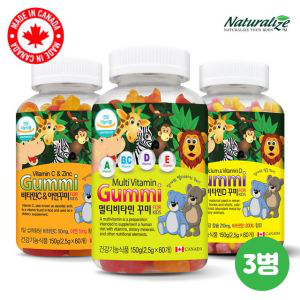

In [86]:
pil.open(f'{dname}/test.png')

In [94]:
for idx, data in df3[:5].iterrows(): 
    print(idx, data['img'])
    response = requests.get(data['img'])
    with open(f'{dname}/{idx}.png', 'wb') as file:  # 'rt'
        file.write(response.content)

0 http://gdimg.gmarket.co.kr/3113057185/still/300?ver=20230825
1 http://gdimg.gmarket.co.kr/3075338164/still/300?ver=20230825
2 http://gdimg.gmarket.co.kr/2105251652/still/300?ver=20230825
3 http://gdimg.gmarket.co.kr/2219928058/still/300?ver=20230825
4 http://gdimg.gmarket.co.kr/3139517831/still/300?ver=20230825


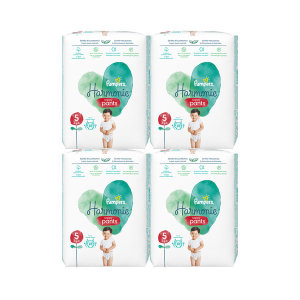

In [95]:
pil.open(f'{dname}/3.png')

썸네일 이미지